In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

In [2]:
data_folder = 'C:/Users/thoma/Documents/ADA_Projet_Data/MovieSummaries/'

# 1.Datasets creation

## 1.1 Import the data

In [3]:
movie_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_name",
    "Movie_release_date",
    "Movie_box_office_revenue",
    "Movie_runtime",
    "Movie_languages", # Freebase ID:name tuples
    "Movie_countries", # Freebase ID:name tuples
    "Movie_genres"] # Freebase ID:name tuples

char_col_name = ["Wikipedia_movie_ID",
    "Freebase_movie_ID",
    "Movie_release_date",
    "Character_name",
    "Actor_date_of_birth",
    "Actor_gender",
    "Actor_height_m", # in meters
    "Actor_ethnicity", # Freebase ID
    "Actor_name",
    "Actor_age_at_movie_release",
    "Freebase_character_actor_map_ID",
    "Freebase_character_ID",
    "Freebase_actor_ID"]

In [4]:
df_movie = pd.read_csv(data_folder+'movie.metadata.tsv', delimiter = '\t', names = movie_col_name, header = None)
df_char = pd.read_csv(data_folder+'character.metadata.tsv', delimiter = '\t', names = char_col_name, header = None)

In [5]:
print("Shape of the movie dataset:", df_movie.shape)
print("Shape of the character dataset:", df_char.shape)

Shape of the movie dataset: (81741, 9)
Shape of the character dataset: (450669, 13)


## 1.2 Merging the datasets

The idea is to have all the characterisitics in one single variable

In [6]:
# We check if the two datasets have identical columns
common_col = set(movie_col_name) & set(char_col_name)
print(f"We have {len(common_col)} common columns")

We have 3 common columns


In [7]:
#We merge the two datasets
merged_df = pd.merge(df_movie, df_char, on=['Wikipedia_movie_ID', 'Freebase_movie_ID'], how='inner', suffixes=('', '_y'))
merged_df['Movie_release_date'] = merged_df['Movie_release_date'].combine_first(merged_df['Movie_release_date_y'])
merged_df.drop('Movie_release_date_y', axis =1, inplace = True, errors='ignore')

print("Shape of the merged dataset: ", merged_df.shape)
merged_df.head(2)


Shape of the merged dataset:  (450669, 19)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Lieutenant Melanie Ballard,1974-08-15,F,1.78,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


## 1.3 Managing data types

As we want to work with the dates, the ages, the genders we have to make sure that the data types are the good ones

In [8]:
merged_df['Movie_release_date'] = pd.to_datetime(merged_df['Movie_release_date'], errors='coerce').dt.normalize()
merged_df['Actor_date_of_birth'] = pd.to_datetime(merged_df['Actor_date_of_birth'], errors='coerce').dt.normalize()

print(merged_df.dtypes)

Wikipedia_movie_ID                          int64
Freebase_movie_ID                          object
Movie_name                                 object
Movie_release_date                 datetime64[ns]
Movie_box_office_revenue                  float64
Movie_runtime                             float64
Movie_languages                            object
Movie_countries                            object
Movie_genres                               object
Character_name                             object
Actor_date_of_birth                datetime64[ns]
Actor_gender                               object
Actor_height_m                            float64
Actor_ethnicity                            object
Actor_name                                 object
Actor_age_at_movie_release                float64
Freebase_character_actor_map_ID            object
Freebase_character_ID                      object
Freebase_actor_ID                          object
dtype: object


# 2.Study the raw data

In [9]:
merged_df.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,4.506690e+05,273872,1.010280e+05,4.001990e+05,329887,154824.000000,292556.000000
mean,1.396975e+07,1986-03-21 01:35:51.124612992,6.940705e+07,1.288516e+02,1943-05-29 11:41:52.427588736,1.788893,37.788523
min,3.300000e+02,1894-11-17 00:00:00,1.000000e+04,0.000000e+00,1796-09-20 00:00:00,0.610000,-7896.000000
25%,3.759292e+06,1971-05-26 00:00:00,3.600000e+06,8.800000e+01,1922-09-01 00:00:00,1.676400,28.000000
50%,1.189065e+07,1997-04-04 00:00:00,1.784087e+07,9.700000e+01,1948-02-25 00:00:00,1.750000,36.000000
75%,2.366501e+07,2006-09-05 00:00:00,6.684503e+07,1.120000e+02,1966-07-11 00:00:00,1.830000,47.000000
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,1.079281e+06,2011-09-02 00:00:00,510.000000,103.000000
std,1.079662e+07,NaN,1.469544e+08,5.394664e+03,NaN,4.379940,20.587870


We can observe some interesting points which seems impossible:
- Some actors have negative ages
- Some actors measure up to 510m heigh
- Some movies have a null runtime and a million minutes runtime($\approx 1.9$ years)

# 3.Treating missing values and incoherent values

## 3.1 Filtering incoherent values

We choose to replace the impossible values by NaN as it does not affecter the actor gender

In [10]:
#Replace negative ages by NaN
merged_df['Actor_age_at_movie_release'] = merged_df.query('Actor_age_at_movie_release > 0')['Actor_age_at_movie_release']
#Replace heights superior to 3 meters by NaN
merged_df['Actor_height_m'] = merged_df.query('Actor_height_m < 3')['Actor_height_m']
#Replace null movie runtime by NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime > 1')['Movie_runtime']
#Replace movie runtime superior to 35 days to NaN
merged_df['Movie_runtime'] = merged_df.query('Movie_runtime < 51420')['Movie_runtime']
#Check if there is some movies are released after the actor birth and replace both by NaN
merged_df[['Movie_release_date', 'Actor_date_of_birth']] = merged_df.query('Movie_release_date > Actor_date_of_birth')[['Movie_release_date', 'Actor_date_of_birth']]

merged_df.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,4.506690e+05,205197,1.010280e+05,400163.000000,205197,154809.000000,292123.000000
mean,1.396975e+07,1983-10-11 09:52:52.309536832,6.940705e+07,101.892150,1944-05-26 05:02:33.107501568,1.748177,37.897646
min,3.300000e+02,1894-11-17 00:00:00,1.000000e+04,1.250000,1796-09-20 00:00:00,0.610000,1.000000
25%,3.759292e+06,1965-04-21 00:00:00,3.600000e+06,88.000000,1923-03-24 00:00:00,1.676400,28.000000
50%,1.189065e+07,1994-08-29 00:00:00,1.784087e+07,97.000000,1950-03-26 00:00:00,1.750000,36.000000
75%,2.366501e+07,2005-09-23 00:00:00,6.684503e+07,112.000000,1968-03-06 00:00:00,1.830000,47.000000
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,9360.000000,2008-10-29 00:00:00,2.356000,103.000000
std,1.079662e+07,NaN,1.469544e+08,42.953552,NaN,0.106249,14.078087


## 3.2 Analysis of the missing values

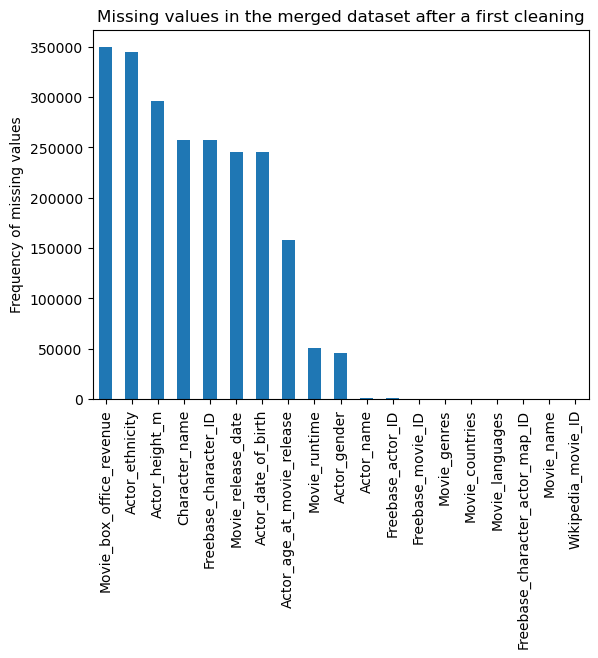

In [11]:
merged_df.isnull().sum().sort_values(ascending=False).plot(kind='bar')
plt.title("Missing values in the merged dataset after a first cleaning")
plt.ylabel('Frequency of missing values')
plt.show()

1. **`Movie_release_date`**  
   - There are still many missing values (176,797), and this appears to be a critical field for historical analyses.
   - Ensure that movies without release dates are filtered out for chronological analyses. Time-trend analyses should be limited to movies with valid and existing dates.
   - **Action:** Create a dataset containing only entries with release dates.

2. **`Movie_box_office_revenue`**  
   - Although the number of missing values has been reduced, this column remains highly incomplete (349,641 missing values).
   - Consider restricting box office impact analyses to films with valid data or applying average/median imputations by genre or decade.
   - **Action:** Create a dataset containing only complete entries for this column.

3. **`Movie_runtime`**  
   - Approximately 50,470 values are still missing. For movie duration analyses, imputing these values with the genre’s average or median runtime can help retain as many films as possible in the analysis.
   - **Note:** This field may not be necessary for the core analyses, so consider removing it if deemed unnecessary.

4. **`Character_name`** and **`Freebase_character_ID`**  
   - Both columns still have a significant proportion of missing values, but they are not essential for genre, box office, or geographic trend analyses.
   - **Action:** These columns may be removed if deemed irrelevant.

5. **`Actor_date_of_birth`** and **`Actor_age_at_movie_release`**  
   - These columns are useful for age-based analysis but still contain a considerable amount of missing data (120,782 and 137,082 missing values, respectively).
   - For age-based analyses, approximate age groups could be used, or focus could be placed on complete records if accuracy is a priority.
   - **Action:** Useful as a potential addition but may be considered optional.

6. **`Actor_gender`**  
   - No missing values remain in this column!
   - Missing data was replaced with "Unknown." A more sophisticated approach could involve inferring gender based on character names (e.g., it is likely that "Mr. Bean" was played by a male actor).
  
7. **`Actor_ethnicity`** and **`Actor_height_m`**  
   - Given the extensive missing values, analyses based on these attributes (particularly ethnicity) are likely to lack reliability with this dataset.
   - **Action:** Exclude these columns from analyses due to high incompleteness and limited utility.

## 3.3 Missing values imputation/treatment
As our project aims to analyse the gender representation across the movie genres, the countries and the actor ages, we need to ensure that there is no missing data.
If so, we need to find a way to reduce their number.

In [12]:
#We replace the missing genders by 'Unknown'
merged_df.loc[merged_df['Actor_gender'].isnull(),'Actor_gender'] = 'Unknown'

In [13]:
#We search for the number of missing actors' ages
#We also check if the actor's age can be calculated knowing the movie release date and the actor's date of birth
age_mask = (merged_df['Actor_age_at_movie_release'].isnull()) & (merged_df['Movie_release_date'].notnull()) & (merged_df['Actor_date_of_birth'].notnull())
count_age_incomplete  = merged_df[age_mask].shape[0]
print(f"We have {count_age_incomplete} missing actors' ages that can be calculated")

We have 21042 missing actors' ages that can be calculated


In [ ]:
#We compute the actors' ages
merged_df.loc[age_mask,'Actor_age_at_movie_release'] = (merged_df['Movie_release_date'] - merged_df['Actor_date_of_birth']).dt.days // 365

merged_df.describe()

,Wikipedia_movie_ID,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Actor_date_of_birth,Actor_height_m,Actor_age_at_movie_release
count,4.506690e+05,205197,1.010280e+05,400163.000000,205197,154809.000000,313165.000000
mean,1.396975e+07,1983-10-11 09:52:52.309536832,6.940705e+07,101.892150,1944-05-26 05:02:33.107501568,1.748177,38.405301
min,3.300000e+02,1894-11-17 00:00:00,1.000000e+04,1.250000,1796-09-20 00:00:00,0.610000,0.000000
25%,3.759292e+06,1965-04-21 00:00:00,3.600000e+06,88.000000,1923-03-24 00:00:00,1.676400,28.000000
50%,1.189065e+07,1994-08-29 00:00:00,1.784087e+07,97.000000,1950-03-26 00:00:00,1.750000,37.000000
75%,2.366501e+07,2005-09-23 00:00:00,6.684503e+07,112.000000,1968-03-06 00:00:00,1.830000,47.000000
max,3.750192e+07,2016-06-08 00:00:00,2.782275e+09,9360.000000,2008-10-29 00:00:00,2.356000,153.000000
std,1.079662e+07,NaN,1.469544e+08,42.953552,NaN,0.106249,14.212519


We now see that there is no more missing missing value for the gender which is good for our data analysis

In [15]:
#ici on créé le dataset final sur lequel nous allons travailler seulement ceux pour lesquels on a la data de sortie du film

merged_df_dr = merged_df[merged_df.Movie_release_date.notnull()]
print(merged_df_dr.isnull().sum())

Wikipedia_movie_ID                      0
Freebase_movie_ID                       0
Movie_name                              0
Movie_release_date                      0
Movie_box_office_revenue           135154
Movie_runtime                       17612
Movie_languages                         0
Movie_countries                         0
Movie_genres                            0
Character_name                      94437
Actor_date_of_birth                     0
Actor_gender                            0
Actor_height_m                     104724
Actor_ethnicity                    141796
Actor_name                              5
Actor_age_at_movie_release              0
Freebase_character_actor_map_ID         0
Freebase_character_ID               94433
Freebase_actor_ID                       0
dtype: int64


# 4.Blabla

## Pas encore eu le temps

In [16]:
#ici on créé une nouvelle colonne release year qui contient l
merged_df_dr = merged_df_dr.copy()
merged_df_dr['Movie_release_date'] = merged_df_dr['Movie_release_date'].astype(str)
#print(merged_df_dr['Movie_release_date'].apply(type))
merged_df_dr.loc[:, 'Release_year'] = merged_df_dr['Movie_release_date'].str[:4].astype(int)
#print(merged_df_dr.Movie_release_date.dt.year)
merged_df_dr


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,Actor_date_of_birth,Actor_gender,Actor_height_m,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450649,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Sylvie,1966-12-20,F,NaN,NaN,Yumi Tōma,25.0,/m/0kr40cd,/m/0kr40ch,/m/08g3fb,1992
450650,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Exegran,1939-10-02,M,NaN,NaN,Yoshisada Sakaguchi,52.0,/m/0kr406x,/m/0kr406_,/m/04gq373,1992
450652,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Maj. Nexx,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr40d9,/m/0kr40df,/m/044_7j,1992
450653,913762,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,1992-05-21,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",Lord Feff,1960-04-28,M,NaN,NaN,Steven Blum,32.0,/m/0kr408g,/m/0kr408l,/m/044_7j,1992


In [17]:

datafirstplot = merged_df_dr.groupby(["Release_year","Actor_gender"]).Release_year.count()
'''
datafirstplot=datafirstplot.reset_index(name='Count')
datafirstplot.head(20)
'''
datafirstplot = pd.crosstab(merged_df_dr['Release_year'],merged_df_dr['Actor_gender'])
#datafirstplot=datafirstplot.reset_index()
#datafirstplot.index.names=["Index"]
datafirstplot
#plt.plot(datafirstplot.index,datafirstplot.Unknown)

Actor_gender,F,M,Unknown
Release_year,,,
1894,0,1,0
1896,1,1,0
1897,0,1,0
1900,1,2,0
1902,1,1,0
...,...,...,...
2011,2589,4573,12
2012,1388,2534,3
2013,176,414,0


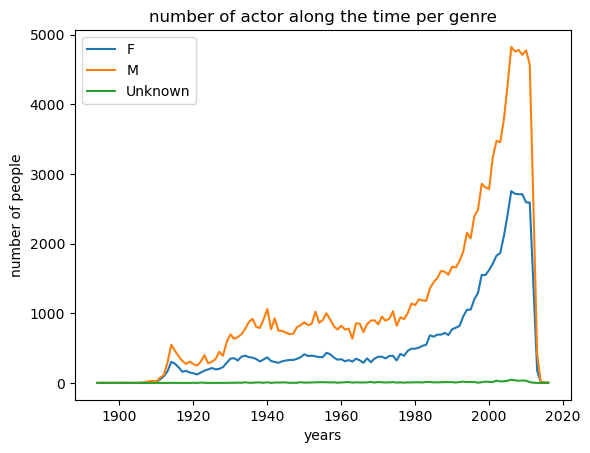

In [18]:
'''
i=0
for index, row in datafirstplot.iterrows():
    plt.plot(datafirstplot.index,datafirstplot.values)
    i=i+1
    print(i)
'''
for column in datafirstplot.columns:
    plt.plot(datafirstplot.index,datafirstplot[column],label=column)
    
plt.xlabel("years")
plt.ylabel("number of people")
plt.title("number of actor along the time per genre")
plt.legend()
plt.show()


In [19]:
# Convertit les chaînes en dictionnaires
merged_df_dr['Movie_genres'] = merged_df_dr['Movie_genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Fonction pour extraire le premier genre
def extract_first_genre(genre_dict):
    if isinstance(genre_dict, dict):
        return next(iter(genre_dict.values()), None)
    return None
def extract_all_genres(genre_dict):
    if isinstance(genre_dict, dict):
        # Récupère toutes les valeurs du dictionnaire
        return list(genre_dict.values())
    return None
# Crée une nouvelle colonne 'principal_genre' avec le premier genre
merged_df_dr['principal_genre'] = merged_df_dr['Movie_genres'].apply(extract_first_genre)




In [20]:
merged_df_dr['Movie_countries'] = merged_df_dr['Movie_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df_dr['countries'] = merged_df_dr['Movie_countries'].apply(extract_first_genre)

In [21]:
merged_df_dr['Movie_languages'] = merged_df_dr['Movie_languages'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
merged_df_dr['language'] = merged_df_dr['Movie_languages'].apply(extract_first_genre)

In [22]:
merged_df_dr.head(3)


,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year,principal_genre,countries,language
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Akooshay,...,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001,Thriller,United States of America,English Language
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Lieutenant Melanie Ballard,...,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001,Thriller,United States of America,English Language
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/06n90': 'Science...",Desolation Williams,...,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001,Thriller,United States of America,English Language


In [23]:
#Ici on va créer tout les subdatasets qui nous intéresse
data_boxof = merged_df_dr[merged_df_dr.Movie_box_office_revenue.notnull()]
data_runtime = merged_df_dr[merged_df_dr.Movie_runtime.notnull()]
data_age = merged_df_dr[merged_df_dr.Actor_age_at_movie_release.notnull()]
data_ethn = merged_df_dr[merged_df_dr.Actor_ethnicity.notnull()]
data_height = merged_df_dr[merged_df_dr.Actor_height_m.notnull()]


In [24]:
merged_df_dr[merged_df_dr.countries== "France"].head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Character_name,...,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Release_year,principal_genre,countries,language
148,22087420,/m/05pckh0,"Ferdinando I, re di Napoli",1959-12-22,NaN,105.0,{'/m/02bjrlw': 'Italian Language'},"{'/m/0f8l9c': 'France', '/m/03rjj': 'Italy'}","{'/m/01z4y': 'Comedy', '/m/01g6gs': 'Black-and...",NaN,...,NaN,Peppino De Filippo,56.0,/m/05tfhgz,NaN,/m/08392m,1959,Comedy,France,Italian Language
760,22066590,/m/05p3428,The Bigamist,1956-09-20,NaN,110.0,{'/m/02bjrlw': 'Italian Language'},"{'/m/0f8l9c': 'France', '/m/03rjj': 'Italy'}","{'/m/05p553': 'Comedy film', '/m/01g6gs': 'Bla...",Amalia,...,NaN,Anita Durante,59.0,/m/0n5n10z,/m/0n5n111,/m/0kb1wvf,1956,Comedy film,France,Italian Language
761,22066590,/m/05p3428,The Bigamist,1956-09-20,NaN,110.0,{'/m/02bjrlw': 'Italian Language'},"{'/m/0f8l9c': 'France', '/m/03rjj': 'Italy'}","{'/m/05p553': 'Comedy film', '/m/01g6gs': 'Bla...",Mario De Santis,...,/m/0222qb,Marcello Mastroianni,31.0,/m/05tc7sd,/m/0n5n11c,/m/015gjr,1956,Comedy film,France,Italian Language


# 5.First plots

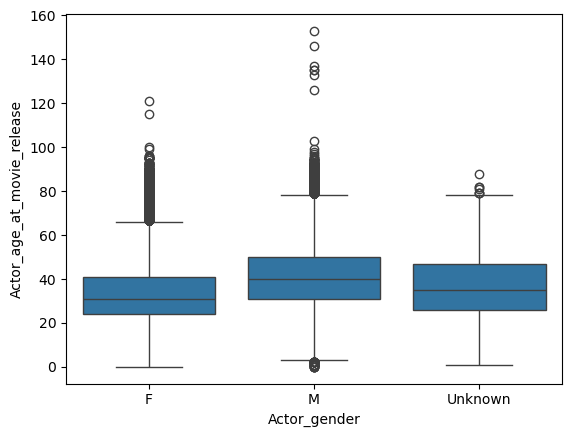

In [25]:
box_male = sns.boxplot(x=merged_df_dr["Actor_gender"], y=merged_df_dr["Actor_age_at_movie_release"], data=merged_df_dr.loc[merged_df_dr['Actor_gender'].isin(['M', 'F'])])